In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from concurrent.futures import ProcessPoolExecutor, as_completed

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v8_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v8_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

train_log = pd.read_csv('../train_log.csv')
test_log = pd.read_csv('../test_log.csv')

In [3]:
train_df

,session_id,yado_no,target,predict_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0,1,-1,0,1,-1,-1,0,0,205.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,212.0,364.0,40.0,3.0,1.0,1.0,4,6,8,11,335580,36215,13849,13529,881,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037868,0.036485
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0,2,-1,0,1,-1,-1,0,0,76.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,150.0,845.5,113.0,10.0,6.0,6.0,4,6,8,11,335580,36215,13849,13529,785,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041860,0.040170
2,000104bdffaaad1a1e0a9ebacf585f33,902,0,3,-1,0,1,-1,-1,0,0,240.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,154.0,785.5,103.0,9.0,5.0,5.0,4,6,8,11,335580,36215,13849,13529,675,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041742,0.040073
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0,4,-1,0,1,-1,-1,0,0,111.0,1.0,0,1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,134.0,1114.0,143.0,16.0,12.0,12.0,4,6,8,11,335580,36215,13849,13529,671,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.032967,0.031939
4,000104bdffaaad1a1e0a9ebacf585f33,5490,0,5,-1,0,1,-1,-1,0,0,116.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,143.0,945.0,126.0,13.0,9.0,9.0,4,6,8,11,335580,36215,13849,13529,911,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037037,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,0,5,-1,0,2,-1,-1,0,1,-1.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,50.0,4353.0,509.0,63.0,25.0,7.0,4,24,148,227,335580,38742,11787,2856,209,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.017964,0.017748
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0,6,-1,0,2,-1,-1,0,0,198.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,138.0,1039.0,136.0,18.0,11.0,5.0,4,24,148,227,335580,38742,11787,2856,338,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.018450,0.018177
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0,7,-1,0,2,-1,-1,0,0,94.0,1.0,1,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,840f2157ec5bb4f5501a3ace2f4ef8d1,120.0,1408.0,193.0,27.0,15.0,9.0,4,24,148,228,335580,38742,11787,8931,555,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.035605,0.034342,0.022624,0.022163
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,0,8,-1,0,2,-1,-1,0,0,310.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b0

In [4]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

0    2777527
Name: seen_yad, dtype: int64
0    1683604
Name: seen_yad, dtype: int64


### CatBoost Ranker

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import label_ranking_average_precision_score
from catboost import CatBoostRanker, Pool

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad', 'TE_wid_cd', 'TE_ken_cd', 'TE_lrg_cd', 'TE_sml_cd', 'TE_yado_no')] # seen_yadも入れる 
cat_cols = ['yado_no']+ ['label_wid_cd', 'label_ken_cd', 'label_lrg_cd', 'label_sml_cd'] 
target = 'target'  # ターゲット変数の列名
query_ids =  'session_id' #train_df['session_id'].values  # クエリIDの列名

# CatBoost のパラメータ
params = {
    'loss_function': 'YetiRank',  # YetiRankPairwise という選択肢もあります
    'learning_rate': 0.2,
    'iterations': 5000,
    'depth': 6,
    'random_seed': 42531,
    "cat_features": cat_cols,
}

In [7]:
map_scores = []  # 各foldのMAPスコアを保存するリスト
test_pred = []   # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化

for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # データセットの作成
    train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids], cat_features=cat_cols)
    val_pool = Pool(data=valid_data[features], label=valid_data[target], group_id=valid_data[query_ids], cat_features=cat_cols)

    # モデルの訓練
    model = CatBoostRanker(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=True)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(val_pool)
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存

    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    test_pred.append(model.predict(test_df[features]))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')


Groupwise loss function. OneHotMaxSize set to 10
0:	test: 0.1956266	best: 0.1956266 (0)	total: 1.5s	remaining: 2h 4m 38s
1:	test: 0.2115864	best: 0.2115864 (1)	total: 2.8s	remaining: 1h 56m 46s
2:	test: 0.2131303	best: 0.2131303 (2)	total: 4.42s	remaining: 2h 2m 42s
3:	test: 0.2167812	best: 0.2167812 (3)	total: 5.87s	remaining: 2h 2m 13s
4:	test: 0.2179811	best: 0.2179811 (4)	total: 7.08s	remaining: 1h 57m 58s
5:	test: 0.2197009	best: 0.2197009 (5)	total: 8.26s	remaining: 1h 54m 31s
6:	test: 0.2206343	best: 0.2206343 (6)	total: 9.78s	remaining: 1h 56m 14s
7:	test: 0.2218841	best: 0.2218841 (7)	total: 11.3s	remaining: 1h 57m 9s
8:	test: 0.2230189	best: 0.2230189 (8)	total: 12.8s	remaining: 1h 57m 55s
9:	test: 0.2238565	best: 0.2238565 (9)	total: 14.3s	remaining: 1h 59m 18s
10:	test: 0.2245837	best: 0.2245837 (10)	total: 16s	remaining: 2h 46s
11:	test: 0.2250668	best: 0.2250668 (11)	total: 17.5s	remaining: 2h 1m 4s
12:	test: 0.2255410	best: 0.2255410 (12)	total: 19.3s	remaining: 2h 3m 6s

              Feature Id  Importances
0             predict_no     0.038246
1             max_seq_no     0.007187
2          count_yado_no     0.006058
3        TE_yado_no_mean     0.004854
4             popularity     0.001564
5           count_lrg_cd     0.001508
6         TE_yado_no_var     0.001421
7           count_sml_cd     0.001327
8         total_room_cnt     0.001048
9          TE_sml_cd_var     0.000976
10           ken_cd_rank     0.000944
11           wid_cd_rank     0.000859
12           sml_cd_rank     0.000737
13        TE_sml_cd_mean     0.000727
14           lrg_cd_rank     0.000531
15          label_lrg_cd     0.000501
16             onsen_flg     0.000385
17        TE_lrg_cd_mean     0.000348
18        TE_ken_cd_mean     0.000283
19          overall_rank     0.000261
20          count_ken_cd     0.000224
21     kd_conv_walk_5min     0.000214
22         TE_lrg_cd_var     0.000202
23        TE_wid_cd_mean     0.000193
24      wireless_lan_flg     0.000128
25          

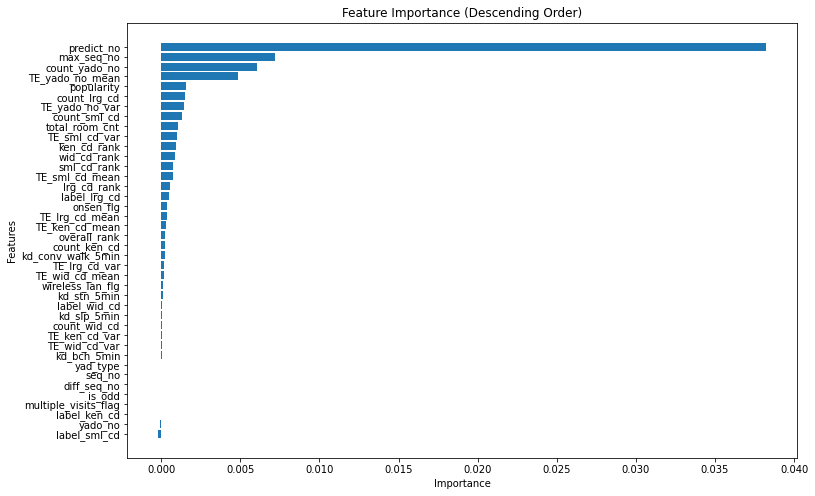

In [8]:
import matplotlib.pyplot as plt

# トレーニングデータセットでのPoolを作成（もしまだ作成していない場合）
#train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids])

# 特徴量の重要度を取得（トレーニングデータセットを使用）
feature_importances = model.get_feature_importance(train_pool, prettified=True)

# 特徴量の重要度を降順に並び替え
feature_importances.sort_values(by='Importances', ascending=False, inplace=True)

# 特徴量の重要度を表示
print(feature_importances)

# 特徴量の重要度をグラフで表示（降順）
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature Id'], feature_importances['Importances'])
plt.gca().invert_yaxis()  # y軸を逆順にして、重要度が高い特徴量を上に表示
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Descending Order)')
plt.show()



In [9]:
# train_dfのyado_noをyad_noに変更
train_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [10]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yad_no', 'oof_pred']].head()

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,1.586113
1,000104bdffaaad1a1e0a9ebacf585f33,7749,1.102676
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.569192
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0.348939
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.799389


In [11]:
train_df[['session_id', 'yad_no', 'oof_pred']]

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,1.586113
1,000104bdffaaad1a1e0a9ebacf585f33,7749,1.102676
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.569192
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0.348939
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.799389
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.290984
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.613134
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.782355
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-3.478581


In [12]:
oof_pred_df = train_df[['session_id', 'yad_no', 'oof_pred']]
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,1.586113
1,000104bdffaaad1a1e0a9ebacf585f33,7749,1.102676
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.569192
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0.348939
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.799389
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.290984
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.613134
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.782355
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-3.478581


In [13]:
# アンサンブル用にoof_predを保存
oof_pred_df.to_csv('../ensemble/catRanker_ver4_oof_pred.csv', index=False)

In [14]:
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,1.586113
1,000104bdffaaad1a1e0a9ebacf585f33,7749,1.102676
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.569192
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0.348939
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.799389
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.290984
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.613134
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.782355
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-3.478581


### CVの計算

In [15]:
train_log_df = pd.read_csv('../train_log.csv')
train_label_df = pd.read_csv('../train_label.csv')

In [16]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
oof_pred_df = oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
oof_pred_df.set_index('session_id', inplace=True)

In [17]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = '000104bdffaaad1a1e0a9ebacf585f33'
recommendations = get_top_recommendations(session_id_to_check, oof_pred_df)
print(recommendations)

[3894, 7749, 902, 11380, 1284, 254, 5490, 12491, 4072]
CPU times: user 151 ms, sys: 0 ns, total: 151 ms
Wall time: 153 ms


In [18]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = train_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = train_label_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(train_label_df))}
    for future in tqdm(as_completed(future_to_session), total=len(train_label_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 288698/288698 [00:42<00:00, 6808.50it/s]


In [19]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
result_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
result_df.columns = [f'predict_{i}' for i in range(result_df.shape[1])]
# 最初の列にセッションIDを追加する
# result_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
result_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,2808,997,5289,12846,3324,11882,9208,9207,9209
1,8253,1586,8747,2570,3725,11104,2259,8225,4488,3564
2,4863,5238,2957,13642,1967,9039,6722,4355,7509,11724
3,626,755,13549,109,1341,2272,13296,11715,7812,7872
4,96,3894,7749,902,11380,1284,254,5490,12491,4072
...,...,...,...,...,...,...,...,...,...,...
288693,10955,5719,13079,13210,3725,13717,10522,1586,8677,2876
288694,4767,513,963,2900,5299,8703,6654,399,8465,3940
288695,7308,3566,4040,10364,4398,2087,7820,12240,9558,844
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


### 要素の集合にバグがないかを確認

In [20]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [21]:
# 既存のDataFrameを読み込む
df1 = candidate_ver15_train
df2 = result_df#.drop(columns=['has_duplicates'])
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


### 順位変動のあったカラムを確認する

In [23]:
candidate_ver15_train

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [24]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != result_df

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(len(mismatched_rows))

一致していない行のインデックス：
0          True
1          True
2          True
3          True
4          True
          ...  
288693     True
288694     True
288695     True
288696    False
288697    False
Length: 288698, dtype: bool
一致していない行：
285070


In [25]:
candidate_ver15_train[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
5,10510,4823,12544,5369,1,9207,9199,9200,9201,9202
6,7531,441,2480,13240,10378,2282,7273,10442,12774,4574
7,4744,9508,7681,10362,12962,1755,12125,12464,111,10544
8,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
9,10478,379,550,3278,3483,6592,9773,9430,4303,2806


In [27]:
result_df[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,2808,997,5289,12846,3324,11882,9208,9207,9209
1,8253,1586,8747,2570,3725,11104,2259,8225,4488,3564
2,4863,5238,2957,13642,1967,9039,6722,4355,7509,11724
3,626,755,13549,109,1341,2272,13296,11715,7812,7872
4,96,3894,7749,902,11380,1284,254,5490,12491,4072
5,12544,4823,10510,5369,9199,9207,9200,9201,9202,1
6,7531,4574,12774,2480,7273,2282,13240,441,10378,10442
7,111,10362,12464,1755,4744,10544,9508,12962,12125,7681
8,13220,899,3644,3802,9723,4014,1227,13702,12432,2164
9,10478,3278,6592,9773,379,2806,3483,550,4303,9430


In [28]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.values

In [29]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [30]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.4584261364129948


In [31]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [32]:
# 欠損がないかをチェック
result_df.isnull().sum(axis=1).sum()

0

In [33]:
result_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,4101,2808,997,5289,12846,3324,11882,9208,9207,9209,False
1,8253,1586,8747,2570,3725,11104,2259,8225,4488,3564,False
2,4863,5238,2957,13642,1967,9039,6722,4355,7509,11724,False
3,626,755,13549,109,1341,2272,13296,11715,7812,7872,False
4,96,3894,7749,902,11380,1284,254,5490,12491,4072,False


### 推論用の候補テーブルを作成する

In [34]:
test_log_df = pd.read_csv('../test_log.csv')
test_session_df = pd.read_csv('../test_session.csv')

In [35]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[1.50415738 0.68903346 0.88198982 ... 0.50093436 0.32246813 0.68337665]
1683604


In [36]:
# test_predの形を調べる
print(np.array(test_pred).shape)

(5, 1683604)


In [37]:
# test_dfのyado_noをyad_noに変更
test_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [38]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yad_no', 'target']].head()

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,1.504157
1,00001149e9c73985425197104712478c,4714,0.689033
2,00001149e9c73985425197104712478c,2680,0.881990
3,00001149e9c73985425197104712478c,4420,-0.068839
4,00001149e9c73985425197104712478c,5466,0.059549


In [39]:
test_oof_pred_df = test_df[['session_id', 'yad_no', 'target']]
test_oof_pred_df

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,1.504157
1,00001149e9c73985425197104712478c,4714,0.689033
2,00001149e9c73985425197104712478c,2680,0.881990
3,00001149e9c73985425197104712478c,4420,-0.068839
4,00001149e9c73985425197104712478c,5466,0.059549
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.679458
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.485908
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.500934
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.322468


In [44]:
# test_oof_pred_dfのカラム名を変更
test_oof_pred_df.rename(columns={'target': 'oof_pred'}, inplace=True)
test_oof_pred_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,1.504157
1,00001149e9c73985425197104712478c,4714,0.689033
2,00001149e9c73985425197104712478c,2680,0.881990
3,00001149e9c73985425197104712478c,4420,-0.068839
4,00001149e9c73985425197104712478c,5466,0.059549
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.679458
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.485908
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.500934
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.322468


In [45]:
test_oof_pred_df

,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,1.504157
1,00001149e9c73985425197104712478c,4714,0.689033
2,00001149e9c73985425197104712478c,2680,0.881990
3,00001149e9c73985425197104712478c,4420,-0.068839
4,00001149e9c73985425197104712478c,5466,0.059549
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.679458
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.485908
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.500934
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.322468


In [41]:
# アンサンブル用にoof_predを保存
test_oof_pred_df.to_csv('../ensemble/catRanker_ver4_test_pred.csv', index=False)

In [46]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
test_oof_pred_df = test_oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
test_oof_pred_df.set_index('session_id', inplace=True)

In [50]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = 'ffffe984aafd6127ce8e43e3ca40c79d'
recommendations = get_top_recommendations(session_id_to_check, test_oof_pred_df)
print(recommendations)

[10729, 11723, 12767, 1891, 5623, 3781, 11994, 12620, 867, 634]
CPU times: user 95.2 ms, sys: 3.96 ms, total: 99.2 ms
Wall time: 98.9 ms


In [47]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = test_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = test_session_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=test_oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(test_session_df))}
    for future in tqdm(as_completed(future_to_session), total=len(test_session_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 174700/174700 [00:27<00:00, 6244.32it/s]


In [48]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
test_expanded_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
test_expanded_df.columns = [f'predict_{i}' for i in range(test_expanded_df.shape[1])]
# 最初の列にセッションIDを追加する
# expanded_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,2680,4714,5466,4420,9830,9534,5785,6563
1,613,143,7014,8108,4066,6555,11923,12862,6129,11237
2,757,9190,7710,9910,1774,10485,6721,410,6730,13570
3,12341,3359,6991,1542,5080,13521,10861,4180,6489,10746
4,9020,10826,9623,3476,2862,12029,3854,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,2278,10997,9743,10042,3440
174696,13220,899,9723,3802,13702,4014,1227,3644,2164,12432
174697,12939,13719,13797,13241,7308,2087,11037,5810,11796,8143
174698,2373,3100,2692,10287,1687,13672,3002,4976,5513,12281


In [49]:
# 各行内で重複があるかどうかをチェック

def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
test_expanded_df['has_duplicates'] = test_expanded_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = test_expanded_df[test_expanded_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [50]:
# 欠損がないかをチェック
test_expanded_df.isnull().sum(axis=1).sum()

0

In [51]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [52]:
# 行ごとに要素の集合が異なっていないかをチェック
import pandas as pd

# 既存のDataFrameを読み込む
df1 = candidate_ver15_test
df2 = test_expanded_df.drop('has_duplicates', axis=1)
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)

0


In [53]:
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [54]:
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,3560,11561,2680,4714,5466,4420,9830,9534,5785,6563,False
1,613,143,7014,8108,4066,6555,11923,12862,6129,11237,False
2,757,9190,7710,9910,1774,10485,6721,410,6730,13570,False
3,12341,3359,6991,1542,5080,13521,10861,4180,6489,10746,False
4,9020,10826,9623,3476,2862,12029,3854,3844,5372,6161,False
...,...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,2278,10997,9743,10042,3440,False
174696,13220,899,9723,3802,13702,4014,1227,3644,2164,12432,False
174697,12939,13719,13797,13241,7308,2087,11037,5810,11796,8143,False
174698,2373,3100,2692,10287,1687,13672,3002,4976,5513,12281,False


In [55]:
test_expanded_df.drop(columns=['has_duplicates']).to_csv('../submissions/catRanker_ver4.csv', index=False)